In [1]:
import os
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

homedir=os.getenv("HOME")
path_to_dir = homedir+'/Desktop/v2-20220820/'

In [2]:
v2_main = Table.read(homedir+'/v2_snrcoadd.fits')
v2_env = Table.read(path_to_dir+'vf_v2_environment.fits')
magphys = Table.read(path_to_dir+'vf_v2_magphys_legacyExt_mergedNS.fits')

#mass = magphys['logMstar_med']
#sfr = magphys['logSFR_med']
phot=Table.read(path_to_dir+'vf_v2_legacy_ephot.fits')['FLUX_AP02_W3']

magphys_flag = (magphys['magphysFlag'])
clusflag = v2_env[magphys_flag]['cluster_member']
snr_flag = v2_main['SNRflag']

vcosmic = v2_env['Vcosmic']

meters = (vcosmic/68)*3.08e22
flux = phot*1e-26  #W/m^2/Hz
lum = flux*(4*np.pi*meters**2)  #W/Hz

### Generate a plot of W3 luminosity as a function of distance, color-coded according to stellar mass from MAGPHYS.

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(vcosmic[magphys_flag],lum[magphys_flag],alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic[magphys_flag&snr_flag],lum[magphys_flag&snr_flag],alpha=0.5,
            c=mass[magphys_flag&snr_flag],cmap='viridis',label='W3 SNR cut')

plt.yscale('log')
plt.xlabel(r'v$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel('Luminosity (W/Hz)',fontsize=15)
plt.title('W3 Luminosity v. Distance',fontsize=15)
cb = plt.colorbar()
plt.clim(9,12)
cb.set_label(label=r'log(M$_{*}$/M$_{\odot}$) (MAGPHYS)',size=15)
#plt.scatter(vcosmic[clusflag],lum[clusflag],facecolor='None',edgecolor='red',s=100,label='Subsample Cluster Galaxies')

plt.xlim(0,)
plt.ylim(1e22,)
plt.legend()
plt.show()

-----

Now create a plot of MAGPHYS SFR vs. Vcosmic for all points and for those above our WISE SNR cut (i.e., do not apply our mass limit cut!). Use the lowest 5% SFR at the upper 20% of our velocity range to determine our SFR limit.

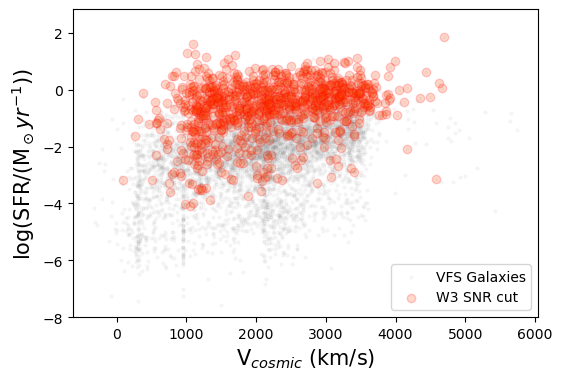

In [5]:
mass = magphys['logMstar_best']
sfr = magphys['logSFR_best']

plt.figure(figsize=(6,4))
plt.scatter(vcosmic[magphys_flag],sfr[magphys_flag],alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic[magphys_flag&snr_flag],sfr[magphys_flag&snr_flag],alpha=0.2,color='orangered',
            edgecolor='red',label='W3 SNR cut')

plt.xlabel(r'V$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel(r'log(SFR/(M$_\odot yr^{-1}$))',fontsize=15)

plt.ylim(-8,)
plt.legend()
plt.show()

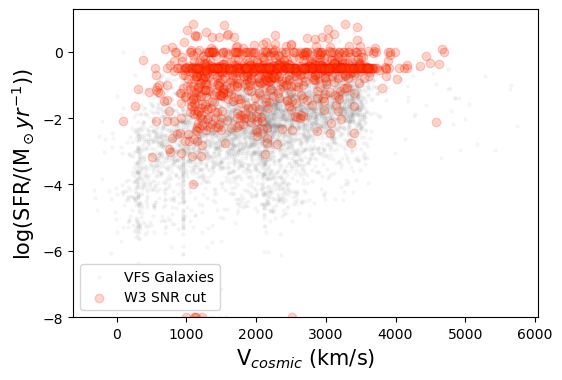

In [6]:
mass = magphys['logMstar_med']
sfr = magphys['logSFR_med']

plt.figure(figsize=(6,4))
plt.scatter(vcosmic[magphys_flag],sfr[magphys_flag],alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic[magphys_flag&snr_flag],sfr[magphys_flag&snr_flag],alpha=0.2,color='orangered',
            edgecolor='red',label='W3 SNR cut')

plt.xlabel(r'V$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel(r'log(SFR/(M$_\odot yr^{-1}$))',fontsize=15)

plt.ylim(-8,)
plt.legend()
plt.show()

Identify the subsample Vcosmic value at and beyond which the elements in the array represent the 20% highest velocities.

In [7]:
#sort vcosmic from least to greatest
v_sorted = np.sort(vcosmic[snr_flag].copy())

#define length of v_sorted
len_v = len(v_sorted)

#multiply length by 0.8 to find the "80%th" index. indices must also be integers.
index = int(len_v*0.8)

#the value at this index...
vlimit = v_sorted[index]

#and lastly, the flag. use to isolate the galaxies with the 20% highest velocities
vlimit_flag = (vcosmic>vlimit)

Of these 20% highest values, we now must isolate the galaxies with the lowest 5% SFR values.

In [8]:
#galaxies that have no magphys errors and which lie above the SNR and vcosmic limits
vcosmic_limit = vcosmic[magphys_flag&snr_flag&vlimit_flag]

#do the same to the v2 catalog
v2_limit = v2_main[magphys_flag&snr_flag&vlimit_flag]

#all SFR values within vcosmic limit
sfr_cut = sfr[magphys_flag&snr_flag&vlimit_flag]   

In [9]:
#sort sfr values from least to greatest
sfr_sorted = np.sort(sfr_cut)

#define length of sfr_sorted
len_sfr = len(sfr_sorted)

#multiply length by 0.05 to find the "5%th" index. indices must also be integers.
index_s = int(len_sfr*0.05)

#the value at this index...(i.e., the 5% boundary beyond which SFRs are higher than desired)
sfrlimit = sfr_sorted[index_s]

#and, lastly, the flag (isolates lowest 5% SFR values within this vcosmic limit)
sfrlimit_flag = (sfr_cut<sfrlimit)

SFR 5% value: -1.318


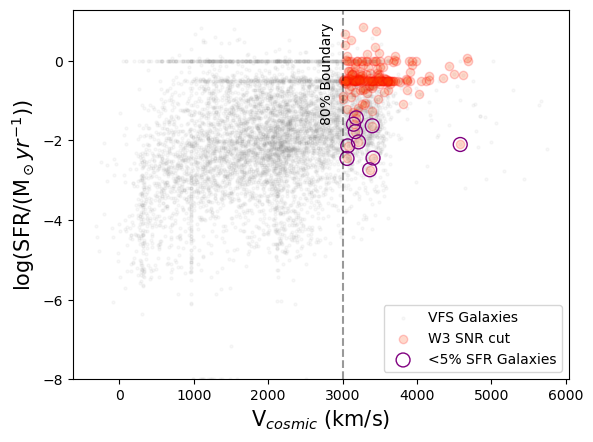

In [12]:
#megazords, combine!

#plt.figure(figsize=(6,4))
plt.scatter(vcosmic,sfr,alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic_limit,sfr_cut,alpha=0.2,color='orangered',
            edgecolor='red',label='W3 SNR cut')

plt.scatter(vcosmic_limit[sfrlimit_flag],sfr_cut[sfrlimit_flag],facecolor='None',edgecolor='purple',s=100,label='<5% SFR Galaxies')

plt.axvline(vlimit,color='black',linestyle='--',alpha=0.4)
plt.text(2850,-1.6,'80% Boundary',fontsize=10,rotation=90,rotation_mode='anchor')
plt.xlabel(r'V$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel(r'log(SFR/(M$_\odot yr^{-1}$))',fontsize=15)

plt.ylim(-8,)
plt.legend()

print(f'SFR 5% value: {sfr_sorted[index_s]}')

plt.savefig(homedir+'/Desktop/sfrvsv.png',dpi=150)

plt.show()

In [45]:
#sfr_best --> -2.090 5% limit
#sfr_med --> -1.398 5% limit

-----

### W1 vs. r-band Diagnostics

In [195]:
vf=Table.read(homedir+'/v2_snrcoadd.fits')
w1 = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_galfit_W1.fits')[vf['subsample_flag']]
magphys = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_magphys_07-Jul-2022.fits')[vf['subsample_flag']]
vf=vf[vf['subsample_flag']]
w3 = Table.read(homedir+'/output_params_W3_psf.fits')
rband = Table.read(homedir+'/output_params_r_psf.fits')

In [196]:
w3_bool = []
for vfid in w3['VFID']:
    w3_bool.append(True) if vfid in vf['VFID'] else w3_bool.append(False)
w3 = w3[w3_bool]
rband = rband[w3_bool]

flags = (w1['CRE']!=0) & (rband['re']!=0) & (w1['CERROR']!=1) & (rband['err_flag']!=1) & (rband['nsersic']<6) & (w1['CN']<6) & (magphys['magphysFlag'])

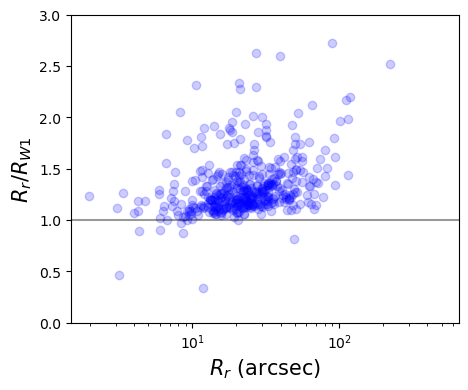

In [201]:
plt.figure(figsize=(5,4))
plt.scatter(rband['re'][flags]*0.262,rband['re'][flags]*0.262/(w1['CRE'][flags]*2.75),
           alpha=0.2,color='blue')
plt.axhline(1,color='black',alpha=0.4)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$R_r$ (arcsec)',fontsize=15)
plt.ylabel(r'$R_r/R_{W1}$',fontsize=15)
plt.ylim(0,3)
plt.show()

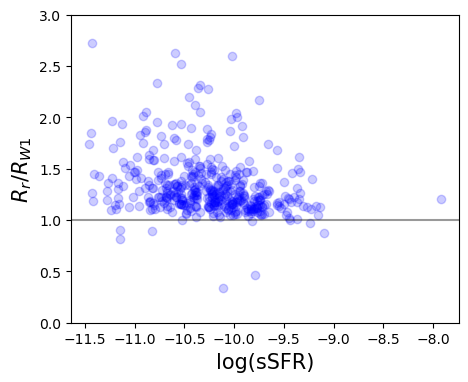

In [202]:
plt.figure(figsize=(5,4))
plt.scatter(magphys['logSFR'][flags]-magphys['logMstar'][flags],
            rband['re'][flags]*0.262/(w1['CRE'][flags]*2.75),
           alpha=0.2,color='blue')
plt.axhline(1,color='black',alpha=0.4)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'log(sSFR)',fontsize=15)
plt.ylabel(r'$R_r/R_{W1}$',fontsize=15)
plt.ylim(0,3)
plt.show()

-----

For every environment, create a vcosmic cumulative histogram. \
Motivation --> if we perform a velocity cut, does it cut more of one environment than another?

In [241]:
v_clus = v2_env['Vcosmic'][v2_env['cluster_member']]
v_rg = v2_env['Vcosmic'][v2_env['rich_group_memb']]
v_pg = v2_env['Vcosmic'][v2_env['poor_group_memb']]
v_fil = v2_env['Vcosmic'][v2_env['filament_member']]
v_field = v2_env['Vcosmic'][v2_env['pure_field']]

vs = [v_clus,v_rg,v_pg,v_fil,v_field]
labels = ['Cluster','Rich Group','Poor Group','Filament','Field']

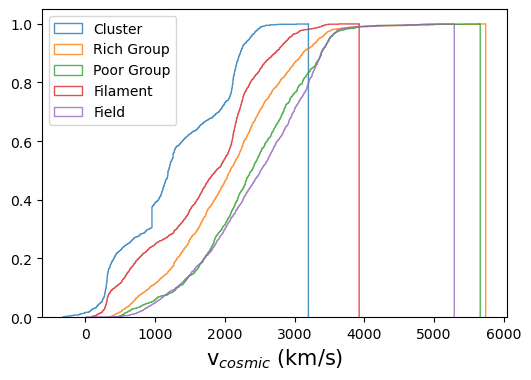

In [252]:
plt.figure(figsize=(6,4))

for i in range(5):
    plt.hist(vs[i],bins=800,alpha=0.8,cumulative=True,density=True,
                     histtype='step',label=labels[i])
plt.xlabel(r'v$_{cosmic}$ (km/s)',fontsize=15)
plt.legend(fontsize=10)